# Lane Detection Project

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.


In [1]:
# Importing necessary libraries
import json  # For working with JSON data
import os    # For interacting with the operating system

import cv2   # OpenCV library for computer vision tasks
import matplotlib.pyplot as plt  # Matplotlib for plotting
import numpy as np  # NumPy for numerical operations
from sklearn.cluster import DBSCAN  # DBSCAN for density-based clustering
import torch  # PyTorch for deep learning
import torch.nn as nn  # PyTorch's neural network module
from torch.nn.modules.loss import _Loss  # Base class for PyTorch loss functions
from torch.autograd import Variable  # Autograd for automatic differentiation
import tqdm  # tqdm for progress bars


In [2]:
# Mounting Google Drive in Google Colab to access and save files
from google.colab import drive

# Mounting the Google Drive to the '/content/drive' directory
drive.mount('/content/drive')


Mounted at /content/drive


## Overview of Data

In [3]:
# Using the !cat command to display the contents of a file named 'readme.md'
# The file is located in the specified directory on Google Drive in a Google Colab environment
!cat /content/drive/MyDrive/unzipped_data/TUSimple/train_set/readme.md


# TuSimple Lane Detection Challenge - Training Dataset

## Description
The lane marking is the main component on the highway. It instructs the vehicles interactively and safely drive on the highway. Lane detection is a critical task in autonomous driving, which provides localization information to the control of the car. We provide video clips for this task, and the last frame of each clip contains labelled lanes. The video clip can help algorithms to infer better lane detection results.

## Dataset Size
3626 video clips, 3626 labelled frames. 
Information of each clip: 20 frames for each one.

## Directory Structure:
   		|
   		|----readme.md  				# description
   		|
   		|----clips/ 					# video clips, 3626 clips
   		|------|
   		|------|----some_clip/			# Sequential images for the clip, 20 frames
   		|------|----...
   		|
   		|----label_data_0313.json			# Label data for lanes
   		|----label_data_0531.json			# Label data for lanes
   		|----label_data_0601.json			# Label data

In [4]:
# Creating an empty list to store data
data = []

# Opening and reading a JSON file containing label data
with open("/content/drive/MyDrive/unzipped_data/TUSimple/train_set/label_data_0313.json") as f:
    # Iterating over each line in the file
    for line in f:
        # Parsing each line as JSON and appending it to the 'data' list
        data.append(json.loads(line))

# Printing the total number of entries in the 'data' list
print(len(data))

# Printing the data at index 21 in the 'data' list
print(data[21])


2858
{'lanes': [[-2, -2, -2, -2, 730, 705, 681, 661, 640, 619, 598, 577, 556, 535, 514, 493, 472, 451, 433, 416, 398, 381, 363, 346, 328, 311, 293, 276, 258, 241, 223, 205, 188, 170, 153, 135, 118, 100, 83, 65, 48, 30, 12, -2, -2, -2, -2, -2], [-2, -2, 884, 848, 831, 816, 816, 815, 815, 814, 814, 814, 817, 820, 823, 826, 829, 832, 835, 838, 842, 845, 848, 851, 854, 857, 860, 863, 866, 869, 872, 875, 878, 881, 885, 888, 891, 894, 897, 900, 903, 906, 909, 912, 915, 918, 921, 924], [-2, -2, -2, 683, 630, 585, 539, 493, 448, 405, 361, 318, 275, 232, 189, 146, 102, 59, 16, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, 923, 915, 923, 930, 947, 967, 986, 1005, 1024, 1043, 1065, 1088, 1111, 1135, 1158, 1181, 1204, 1227, 1250, 1274, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]], 'h_samples': [240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 3

## Semantic and Segmentation Code

We can use the following commands to download the dataset and unpack it from google drive

This is done by creating a class LaneDataSet

We create an instance of the LaneDataset class and retrieving the first item from it. The resulting im, s, and ins are likely the input image, segmentation image, and instance image, respectively

In [5]:
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="/content/drive/MyDrive/unzipped_data/TUSimple/train_set", train=True, size=(512, 256)):
        # Initialize the LaneDataset with dataset path, train/eval mode, and image size
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size  # Width and height of the resized images

        # Determine label files based on the dataset mode
        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        # List to store processed data
        self._data = []

        # Process label files and populate the data list
        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        # Get item at the specified index
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape

        # Resize, convert to grayscale, and add a channel to the image
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]

        # Extract lanes information
        lanes = self._data[idx][1]

        # Create segmentation and instance images
        segmentation_image = self._draw(h, w, lanes, "segmentation")
        instance_image = self._draw(h, w, lanes, "instance")

        # Add a channel to the instance image
        instance_image = instance_image[..., None]

        # Convert images to PyTorch tensors
        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image = torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image

    def __len__(self):
        # Return the total number of entries in the dataset
        return len(self._data)

    def _draw(self, h, w, lanes, image_type):
        # Helper function to draw lanes on a blank image
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        # Resize the image with nearest-neighbor interpolation
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)

        return image

    def _process_label_file(self, file_path):
        # Helper function to process a label file and populate the data list
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info["raw_file"]
                lanes = info["lanes"]
                h_samples = info["h_samples"]
                lanes_coords = []

                # Process lane coordinates
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)

                # Append image and lane coordinates to the data list
                self._data.append((image, lanes_coords))


Test the dataset class.

In this context:

- im is the input image tensor with shape (channel, height, width).
- s is the segmentation image tensor with shape (height, width).
- ins is the instance image tensor with shape (channel, height, width).

This code snippet demonstrates how to access and inspect the shapes of the images from the LaneDataset. You can use these images for further processing or analysis in your lane detection model.

In [6]:
# Creating an instance of the LaneDataset class with default parameters
lanes = LaneDataset()

# Retrieving the first item from the dataset
im, s, ins = lanes[0]

# Printing the shapes of the obtained images
print(im.shape, s.shape, ins.shape)


torch.Size([1, 256, 512]) torch.Size([256, 512]) torch.Size([1, 256, 512])


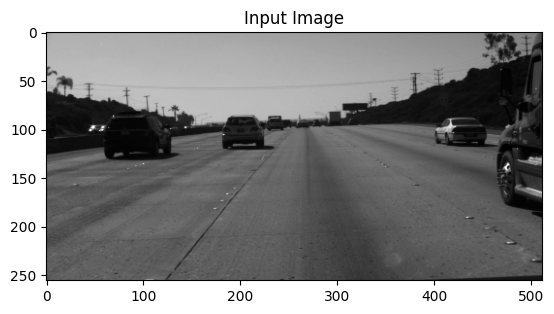

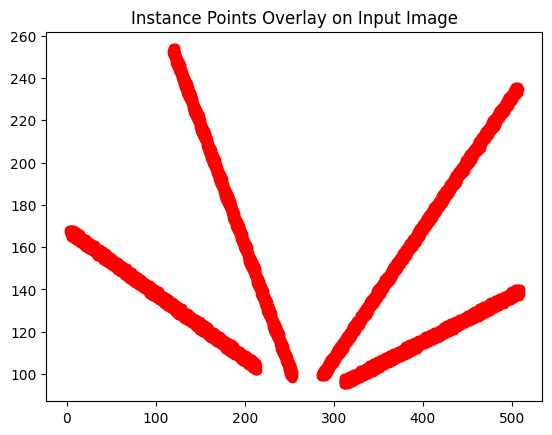

In [7]:
# Display the input image
plt.imshow(im.squeeze(), cmap='gray')  # Assuming it's a grayscale image
plt.title('Input Image')
plt.show()

# Scatter plot overlaying points on the input image based on non-zero elements in the instance image
plt.scatter(x=ins.nonzero(as_tuple=True)[2], y=ins.nonzero(as_tuple=True)[1], c='red', marker='o')
plt.title('Instance Points Overlay on Input Image')
plt.show()


For this task we are going to use ENet architecture. You can read the description in the .

This code defines an implementation of ENet, a deep neural network architecture designed for real-time semantic segmentation. The ENet architecture consists of an initial block, followed by shared and specific branches for segmentation and instance embedding. A brief description can be found in this [paper](https://arxiv.org/pdf/1606.02147.pdf)

Here's a brief overview of the key components and stages:

- Initial Block (InitialBlock class):

This block serves as the initial layer of the network.
It has a main branch (convolution) and an extension branch (max-pooling).
The branches are concatenated and passed through batch normalization and activation.
- Regular Bottleneck (RegularBottleneck class):

This represents a regular bottleneck block with main and extension branches.
The extension branch may include asymmetric, dilated, or regular convolution.
Batch normalization and activation functions are applied after each convolution.
- Downsampling Bottleneck (DownsamplingBottleneck class):

Similar to the regular bottleneck but includes max pooling in the main branch.
The extension branch performs convolution operations.
This block is used for downsampling.
- Upsampling Bottleneck (UpsamplingBottleneck class):

Similar to the regular bottleneck but includes transposed convolution for upsampling.
Used for upsampling in the decoding part of the network.
- ENet (ENet class):

The main ENet model composed of initial, shared, and specific branches.
Shared branches include downsampling and regular bottlenecks.
Specific branches include binary and instance embedding branches.
- Forward Method:

The forward method defines the forward pass through the network.
It includes the initial block, shared branches, and specific branches for both binary segmentation and instance embedding.

The network takes an input tensor and produces two outputs: binary_final_logits for binary segmentation and instance_final_logits for instance embedding.

In [8]:
class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        # Choose activation function based on the 'relu' parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - 3x3 convolution with stride 2
        # The number of output channels is 'out_channels - 1'
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias
        )

        # Extension branch - 3x3 max pooling with stride 2
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Batch normalization for concatenated output
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # Activation function applied after concatenation
        self.out_activation = activation()

    def forward(self, x):
        # Main branch: 3x3 convolution with stride 2
        main = self.main_branch(x)

        # Extension branch: 3x3 max pooling with stride 2
        ext = self.ext_branch(x)

        # Concatenate the outputs of the main and extension branches along the channel dimension
        out = torch.cat((main, ext), 1)

        # Apply batch normalization to the concatenated result
        out = self.batch_norm(out)

        # Apply ReLU or PReLU activation function
        return self.out_activation(out)

class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check if the internal_ratio parameter is within the expected range [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        # Calculate the number of internal channels based on the internal_ratio
        internal_channels = channels // internal_ratio

        # Choose activation function based on the 'relu' parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection
        # The main branch remains unchanged, serving as a shortcut connection

        # Extension branch - 1x1 projection convolution, followed by a convolution (regular, dilated, or asymmetric),
        # another 1x1 convolution, and a spatial dropout. Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric, split it into two parts
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            # Regular convolution
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        # Spatial dropout for regularization
        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        # Apply activation function
        return self.out_activation(out)

class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check if the internal_ratio parameter is within the expected range [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        # Calculate the number of internal channels based on the internal_ratio
        internal_channels = in_channels // internal_ratio

        # Choose activation function based on the 'relu' parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 projection convolution, followed by a convolution (regular, dilated, or
        # asymmetric), another 1x1 convolution. Number of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        # Spatial dropout for regularization
        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        # Apply activation function
        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check if the internal_ratio parameter is within the expected range [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        # Calculate the number of internal channels based on the internal_ratio
        internal_channels = in_channels // internal_ratio

        # Choose activation function based on the 'relu' parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - 1x1 convolution followed by unpooling
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Max unpooling layer
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, transposed convolution, 1x1 convolution. Number of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        # Spatial dropout for regularization
        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        # Apply activation function
        return self.out_activation(out)

class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        # Initial block
        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits


Test the net.

In [9]:
# Create a tensor of shape (1, 1, 256, 512) filled with ones
test_input = torch.ones((1, 1, 256, 512))

# Instantiate the ENet model with binary segmentation output channels set to 2
# and embedding dimensions set to 4
net = ENet(2, 4)

# Forward pass through the network using the test input
binary, instance = net(test_input)

# Print the shape of the binary segmentation output
print("Binary Segmentation Output Shape:", binary.shape)

# Print the shape of the instance segmentation output
print("Instance Segmentation Output Shape:", instance.shape)


Binary Segmentation Output Shape: torch.Size([1, 2, 256, 512])
Instance Segmentation Output Shape: torch.Size([1, 4, 256, 512])


In [10]:
# Forward pass through the ENet model using the loaded image 'im'
s_pred, ins_pred = net(im[None, ...])

# Print the shape of the binary segmentation prediction
print("Binary Segmentation Prediction Shape:", s_pred.shape)

# Print the shape of the instance segmentation prediction
print("Instance Segmentation Prediction Shape:", ins_pred.shape)


Binary Segmentation Prediction Shape: torch.Size([1, 2, 256, 512])
Instance Segmentation Prediction Shape: torch.Size([1, 4, 256, 512])


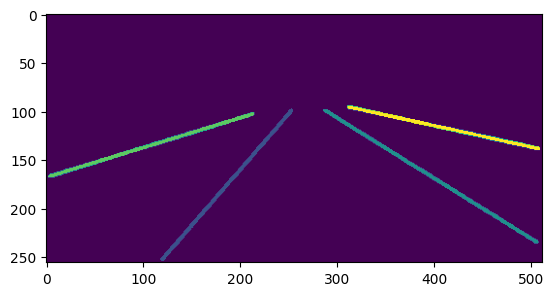

In [11]:
# Assuming 'ins' contains the instance segmentation prediction
plt.imshow(ins.squeeze())


To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [18]:
class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        assert not target.requires_grad

        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples=target.size(0)

        dis_loss=torch.tensor(0.).to(self.device)
        var_loss=torch.tensor(0.).to(self.device)
        reg_loss=torch.tensor(0.).to(self.device)
        for i in range(num_samples):
            clusters=[]
            sample_embedding=input[i,:,:,:]
            sample_label=target[i,:,:].squeeze()
            num_clusters=len(sample_label.unique())-1
            vals=sample_label.unique()[1:]
            sample_label=sample_label.view(sample_label.size(0)*sample_label.size(1))
            sample_embedding=sample_embedding.view(-1,sample_embedding.size(1)*sample_embedding.size(2))
            v_loss=torch.tensor(0.).to(self.device)
            d_loss=torch.tensor(0.).to(self.device)
            r_loss=torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices=(sample_label==vals[j]).nonzero()
                indices=indices.squeeze()
                cluster_elements=torch.index_select(sample_embedding,1,indices)
                Nc=cluster_elements.size(1)
                mean_cluster=cluster_elements.mean(dim=1,keepdim=True)
                clusters.append(mean_cluster)
                v_loss+=torch.pow((torch.clamp(torch.norm(cluster_elements-mean_cluster)-self.delta_var,min=0.)),2).sum()/Nc
                r_loss+=torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx,cluster in enumerate(clusters):
                    if index==idx:
                        continue
                    else:
                        distance=torch.norm(clusters[index]-cluster)#torch.sqrt(torch.sum(torch.pow(clusters[index]-cluster,2)))
                        d_loss+=torch.pow(torch.clamp(self.delta_dist-distance,min=0.),2)
            var_loss+=v_loss/num_clusters
            dis_loss+=d_loss/(num_clusters*(num_clusters-1))
            reg_loss+=r_loss/num_clusters
        return self.alpha*(var_loss/num_samples)+self.beta*(dis_loss/num_samples)+self.gamma*(reg_loss/num_samples)

Test the loss.

In [19]:
# Calculate the loss by calling the instance with ins_pred and ins
DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001)(ins_pred, ins)


tensor(10.5902, grad_fn=<AddBackward0>)

A helper function to compute two losses.

In [20]:
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    # Binary segmentation loss using CrossEntropyLoss
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    # Instance segmentation loss using DiscriminativeLoss
    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cuda")
    instance_loss = ds_loss(instance_output, instance_label)

    # Return both binary and instance losses
    return binary_loss, instance_loss


Now we are ready to train the network. You may want to create validation subset to track metrics.

In [21]:
# Display information about the NVIDIA GPUs using the nvidia-smi command for the project
!nvidia-smi


Wed Dec 20 10:24:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import tqdm

# Hyperparameters
BATCH_SIZE = 8
LR = 5e-4
NUM_EPOCHS = 20

# Create LaneDataset and DataLoader
train_dataset = LaneDataset()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check if GPU is available, else use CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Initialize ENet model and move it to the appropriate device
enet_model = ENet(2, 4)
enet_model.to(device)

# Set up Adam optimizer
params = [p for p in enet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.0002)

# List to store training losses
train_losses = []

# Training loop
for epoch in range(NUM_EPOCHS):
    # Set the model to training mode
    enet_model.train()

    # List to store losses for each batch
    losses = []

    # Iterate over batches in the training data
    for batch in tqdm.tqdm(train_dataloader):
        # Move batch data to the appropriate device
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the model
        binary_logits, instance_emb = enet_model(img)

        # Compute binary and instance segmentation losses
        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)

        # Compute the total loss
        loss = binary_loss + instance_loss

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Store the losses for this batch
        losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))

    # Compute the mean losses over all batches in the epoch
    mean_losses = np.array(losses).mean(axis=0)

    # Print the mean losses for the epoch
    msg = f"Epoch {epoch}: loss = {mean_losses}"
    print(msg)


 18%|█▊        | 74/402 [07:37<34:18,  6.28s/it]

In [ ]:
# Create LaneDataset for evaluation (assuming `LaneDataset` is properly defined)
enet_eval_dataset = LaneDataset(train=False)

# Get the first sample from the evaluation dataset
enet_eval_img_1, *_ = enet_eval_dataset[0]

# Move the evaluation image to the appropriate device (GPU or CPU)
enet_eval_img_1 = enet_eval_img_1.to(device)

# Forward pass through the ENet model for evaluation
binary_logits, instance_emb = enet_model(enet_eval_img_1[None, ...])


In [ ]:
# Get the shapes of the evaluation image, binary logits, and instance embeddings
enet_eval_img_1.shape, binary_logits.shape, instance_emb.shape


(torch.Size([1, 256, 512]),
 torch.Size([1, 2, 256, 512]),
 torch.Size([1, 4, 256, 512]))

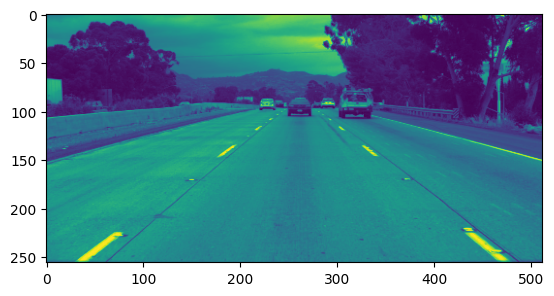

In [ ]:
import matplotlib.pyplot as plt

# Move the tensor to CPU and convert it to a NumPy array
image_to_show = enet_eval_img_1.squeeze().cpu().numpy()

# Display the image using matplotlib
plt.imshow(image_to_show)
plt.show()


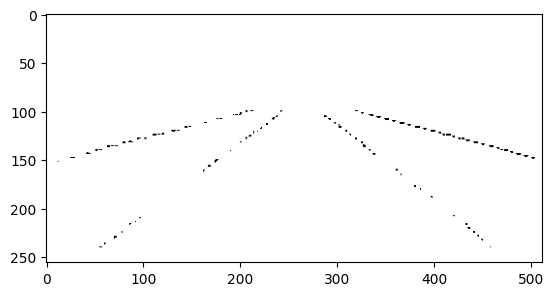

In [ ]:
import matplotlib.pyplot as plt

# Move the tensor to CPU and convert it to a NumPy array
binary_prediction = binary_logits.squeeze().argmax(dim=0).cpu().numpy()

# Display the binary prediction using matplotlib
plt.imshow(binary_prediction, cmap=plt.cm.binary)
plt.show()


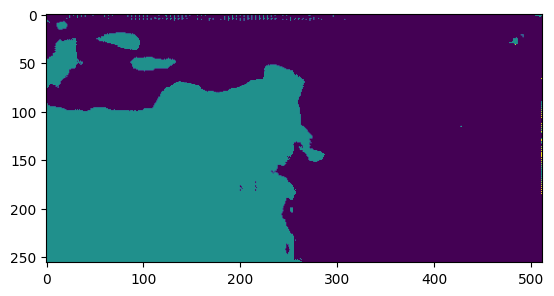

In [ ]:
import matplotlib.pyplot as plt

# Move the tensor to CPU and convert it to a NumPy array
instance_prediction = instance_emb.squeeze().argmax(dim=0).cpu().numpy()

# Display the instance prediction using matplotlib
plt.imshow(instance_prediction, cmap='viridis')  # Choose an appropriate colormap
plt.show()


## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [ ]:
class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="/content/drive//MyDrive/unzipped_data/TUSimple/train_set", train=True, size=(128, 64)):
        # Initialize the dataset with provided parameters
        self.dataset_path = dataset_path
        self.train = train
        self.size = size
        self.image_list = []  # List to store image file names
        self.lanes_list = []  # List to store lane information
        self.max_lanes = 0  # Maximum number of lanes in a sample
        self.max_points = 0  # Maximum number of points in a lane

        # Ensure the dataset path exists
        assert os.path.exists(self.dataset_path), f'Directory {self.dataset_path} does not exist!'

        label_files = []
        # Select label files based on training or evaluation mode
        if self.train:
            label_files.append(os.path.join(self.dataset_path, 'label_data_0313.json'))
            label_files.append(os.path.join(self.dataset_path, 'label_data_0531.json'))
        else:
            label_files.append(os.path.join(self.dataset_path, 'label_data_0601.json'))

        for file in label_files:
            try:
                for line in open(file).readlines():
                    info_dict = json.loads(line)
                    # Extract information from the label files
                    self.image_list.append(info_dict['raw_file'])
                    h_samples = info_dict['h_samples']
                    lanes = info_dict['lanes']
                    self.max_lanes = max(self.max_lanes, len(lanes))
                    xy_list = []

                    # Process each lane in the sample
                    for lane in lanes:
                        y = np.array([h_samples], dtype=np.float64).T
                        x = np.array([lane], dtype=np.float64).T
                        xy = np.hstack((x, y))
                        index = np.where(xy[:, 0] > 2)
                        xy_list.append(xy[index])
                        self.max_points = max(self.max_points, len(xy[index]))
                    self.lanes_list.append(xy_list)
            except BaseException:
                raise Exception(f'Fail to load {file}')

    def __getitem__(self, idx):
        # Get an item from the dataset given its index
        img_path = os.path.join(self.dataset_path, self.image_list[idx])

        # Read and resize the image
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        original_height, original_width, _ = image.shape
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)

        # Transpose image dimensions and normalize values to [0, 1]
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image).float() / 255

        # Create output buffer for lane information with shape [max_lanes, 2, max_points]
        buffer = None

        # Iterate over lanes and concatenate them into the buffer
        for lane in self.lanes_list[idx]:
            lane = np.expand_dims(np.pad(np.swapaxes(lane, 0, 1),
                                         pad_width=((0, 0), (0, self.max_points - lane.shape[0])),
                                         mode='constant',
                                         constant_values=0), 0)

            if buffer is not None:
                buffer = np.concatenate((buffer, lane), 0)
            else:
                buffer = lane

        # Scale lane coordinates to match the resized image dimensions
        buffer[:, 0, :] /= original_width
        buffer[:, 0, :] *= self.size[0]
        buffer[:, 1, :] /= original_height
        buffer[:, 1, :] *= self.size[1]

        # Pad the buffer to handle varying numbers of lanes and points
        ground_truth_trajectory = torch.from_numpy(np.pad(buffer,
                                                          pad_width=((0, self.max_lanes - buffer.shape[0]),
                                                                     (0, 0),
                                                                     (0, 0)),
                                                          mode='constant',
                                                          constant_values=0))

        return image, ground_truth_trajectory

    def __len__(self):
        # Get the total number of items in the dataset
        return len(self.image_list)


In [ ]:
# Create an instance of the HomographyPredictionDataset for training
homography_ds = HomographyPredictionDataset()


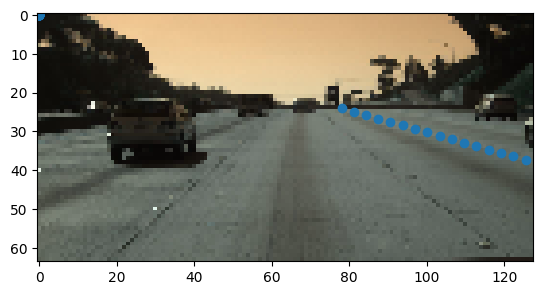

In [ ]:
# Visualize an image from the dataset along with ground truth trajectory points
plt.imshow(homography_ds[1][0].permute(1, 2, 0))
plt.scatter(x=homography_ds[1][1][3][0], y=homography_ds[1][1][3][1])

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that can be used.


In [ ]:
import torch

# Define a homography matrix using a 3x3 torch.Tensor
# Important note: This homography matrix is suitable only for 64x128 resolution

R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])


Let's check the effect of this homography on the image.

In [ ]:
# Download an image using the wget command
!wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

--2023-12-17 18:16:11--  https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.153.4, 162.159.152.4, 2606:4700:7::a29f:9904, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.153.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg [following]
--2023-12-17 18:16:12--  https://miro.medium.com/v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Reusing existing connection to miro.medium.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 91108 (89K) [image/jpeg]
Saving to: ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg.2’

1*b3HiwPg69Rw0L5iIM 100%[===================>]  88.97K  --.-KB/s    in 0.01s   

2023-12-17 18:16:12 (8.50 MB/s) - ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg.2’ saved [91108/91108]



In [ ]:
# Import necessary libraries
from matplotlib import pyplot as plt
import cv2


In [ ]:
# Read an image using matplotlib's imread function
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')


In [ ]:
# Resize the image using OpenCV's resize function to the target size (128, 64)
image = cv2.resize(image, (128, 64))


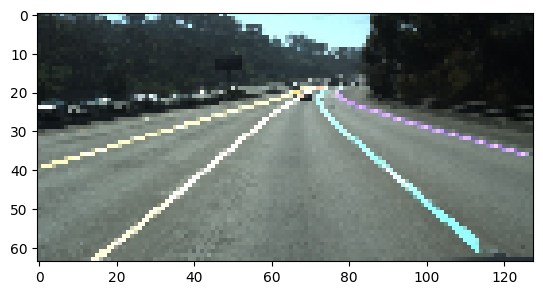

In [ ]:
# Display the resized image using Matplotlib
plt.imshow(image)


In [ ]:
# Convert the PyTorch tensor 'R' to a NumPy array 'R_np'
R_np = R.numpy()

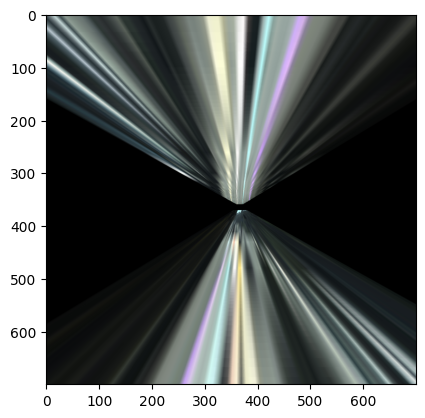

In [ ]:
# Apply perspective transformation using OpenCV's warpPerspective
warped_image = cv2.warpPerspective(image, R_np, dsize=(700, 700))
plt.imshow(warped_image)


As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [ ]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)

        # Linear layers
        self.ln1 = nn.Linear(8192, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        self.ln2 = nn.Linear(1024, 6)

        # Activation functions and pooling
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        # Convolutional layer block 1
        x = self.conv1(x)
        x = self.relu(self.bn1(x))
        x = self.conv2(x)
        x = self.relu(self.bn2(x))
        x = self.maxpool(x)

        # Convolutional layer block 2
        x = self.conv3(x)
        x = self.relu(self.bn3(x))
        x = self.conv4(x)
        x = self.relu(self.bn4(x))
        x = self.maxpool(x)

        # Convolutional layer block 3
        x = self.conv5(x)
        x = self.relu(self.bn5(x))
        x = self.conv6(x)
        x = self.relu(self.bn6(x))
        x = self.maxpool(x)

        # Flatten and apply linear layers
        x = x.view(x.size(0), -1)
        x = self.ln1(x)
        x = self.relu(self.bn7(x))
        x = self.ln2(x)

        return x


Finally, we need to implement the (Homograpgy) loss to fit the network. This is the most difficult part of the project.

In [ ]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, reduction="mean", order=2, device="cpu"):
        """
        Homography loss function for lane detection.

        Parameters:
        - reduction (str): Specifies the reduction to apply to the output. Default: "mean".
        - order (int): The order of the norm used in the loss calculation. Default: 2.
        - device (str): The device on which to perform computations. Default: "cpu".
        """
        super(HomographyLoss, self).__init__(reduction=reduction)
        self._device = device
        self._order = order
        self._R = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device
        )

    def forward(self, inputs, targets):
        """
        Compute the homography loss between the predicted homography corrections (inputs) and the ground truth homography matrices (targets).

        Parameters:
        - inputs (torch.Tensor): Predicted homography corrections (batched).
        - targets (torch.Tensor): Ground truth homography matrices (batched).

        Returns:
        - torch.Tensor: Homography loss.
        """
        assert inputs.shape[0] == targets.shape[0], f"Number of items in batch for inputs and targets must be the same, got N_inputs={inputs.shape[0]}, N_targets={targets.shape[0]}"
        losses = []
        for correction, gt_lanes in zip(inputs, targets):
            for lane in gt_lanes:
                if lane.sum() == 0:
                    continue
                lane_loss = self.compute_loss_for_lane(correction, lane)
                if lane_loss is None:
                    continue
                losses.append(lane_loss)

        return torch.stack(losses).mean()

    def compute_loss_for_lane(self, correction, lane):
        """
        Compute the homography loss for a single lane.

        Parameters:
        - correction (torch.Tensor): Predicted homography correction for the lane.
        - lane (torch.Tensor): Ground truth lane coordinates.

        Returns:
        - torch.Tensor or None: Homography loss for the lane or None if the lane is empty.
        """
        H_correction_indices = [0, 1, 2, 4, 5, 7]
        H_correction = correction.flatten()
        H = self._R.flatten().clone()
        H[H_correction_indices] = H_correction
        H = H.reshape((3, 3))

        points = lane.T
        index = points.nonzero().flatten().max().item() + 1
        points = points[:index, :]
        ones_col = torch.ones(points.shape[0], device=device)
        P = torch.column_stack((points, ones_col)).T.to(torch.float32)
        P_transformed = H @ P

        x_transformed = P_transformed[0, :].T
        y_transformed_squares = P_transformed[1, :] ** 2
        y_transformed = P_transformed[1, :]
        Y = torch.column_stack((y_transformed_squares, y_transformed, ones_col))
        w = torch.linalg.solve(Y.T @ Y, Y.T) @ x_transformed

        x_predicted = Y @ w
        P_predicted = torch.column_stack((x_predicted, y_transformed, ones_col)).T
        P_reprojected = torch.linalg.inv(H.detach()) @ P_predicted

        P_reprojected = torch.div(P_reprojected, P_reprojected[2, :])

        loss = ((points[:, 0].T - P_reprojected[0, :]) ** 2).mean()

        return loss


Test HNet.

In [ ]:
hnet = HNet()

# Create a batch by stacking two samples from the dataset
batch = torch.stack((homography_ds[0][0], homography_ds[1][0]))

# Obtain predicted homography corrections from the HNet model
predicted_corrections = hnet(batch)


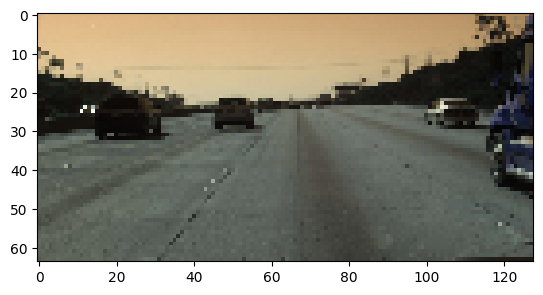

In [ ]:
# Display the original image from the dataset
plt.imshow(homography_ds[0][0].permute(1, 2, 0))


In [ ]:
# Apply the predicted corrections to the original homography matrix
R_corrected_test_image_1 = torch.tensor(
    [
        [R[0, 0] + predicted_corrections[0][0], R[0, 1] + predicted_corrections[0][1], R[0, 2] + predicted_corrections[0][2]],
        [R[1, 0], R[1, 1] + predicted_corrections[0][3], R[1, 2] + predicted_corrections[0][4]],
        [R[2, 0], R[2, 1] + predicted_corrections[0][5], R[2, 2]],
    ]
)
R_corrected_test_image_1


tensor([[ -0.4426, -17.3431, 380.1112],
        [  0.0000, -16.3116, 370.6550],
        [  0.0000,   0.5214,   1.0000]])

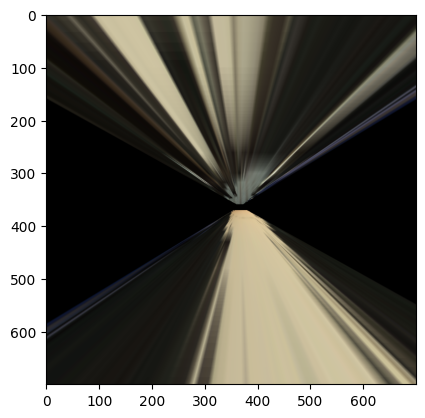

In [ ]:
# Visualize the perspective correction for the first image in the dataset
plt.imshow(cv2.warpPerspective(homography_ds[0][0].permute(1, 2, 0).numpy(), R_np, dsize=(700, 700)))

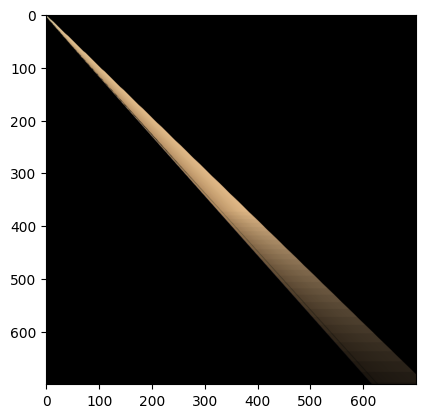

In [ ]:
# Visualize the perspective correction with predicted corrections for the first image in the dataset
plt.imshow(cv2.warpPerspective(homography_ds[0][0].permute(1, 2, 0).numpy(), R_corrected_test_image_1.numpy(), dsize=(700, 700)))

In [ ]:
# Enable anomaly detection for autograd
torch.autograd.set_detect_anomaly(True)

Finally, train the homography net with the 2-nd order polynomial fitting

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [ ]:
# Train the H-Net
BATCH_SIZE = 10
LR = 5e-5
NUM_EPOCHS = 20

# Create the dataset and dataloader
hnet_train_dataset = HomographyPredictionDataset()
hnet_train_dataloader = torch.utils.data.DataLoader(hnet_train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Choose the appropriate device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Initialize the HNet model and move it to the selected device
hnet_model = HNet()
hnet_model.to(device)

# Set up the optimizer and criterion for training
params = [p for p in hnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR)
criterion = HomographyLoss(device=device)

# Training loop
for epoch in range(NUM_EPOCHS):
    hnet_model.train()
    losses = []

    # Iterate over batches in the dataloader
    for inputs, points in tqdm.tqdm(hnet_train_dataloader, leave=False):
        inputs = inputs.to(device)
        points = points.to(device)

        # Forward pass and compute the loss
        coefs = hnet_model(inputs)
        loss = criterion(coefs, points)

        # Backward pass, optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss for this batch
        losses.append(loss.detach().cpu().numpy())

    # Compute and print the mean loss for the epoch
    epoch_loss = np.array(losses).mean()
    print(f"Epoch {epoch}, loss = {epoch_loss}")


Epoch 0, loss = 17096.19026912097


Epoch 1, loss = 5544.437484418239


Epoch 2, loss = 5544.437465141451


Epoch 3, loss = 5544.437445024821


Epoch 4, loss = 5544.437411939684


Epoch 5, loss = 5544.4373581499385


Epoch 6, loss = 5544.437332971798


Epoch 7, loss = 5544.437300340338


Epoch 8, loss = 5544.437230236777


Epoch 9, loss = 5544.437226963561


Epoch 10, loss = 5544.437188973153


Epoch 11, loss = 5544.437153458244


Epoch 12, loss = 5544.437156473964


Epoch 13, loss = 5544.437117370985


Epoch 14, loss = 5544.437082057753


Epoch 15, loss = 5544.437039900479


Epoch 16, loss = 5544.437009085832


Epoch 17, loss = 5544.436973753348


Epoch 18, loss = 5544.436938251431


Epoch 19, loss = 5544.436913581089


# Complete Pipeline


1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.


In [ ]:
class LaneDetector:
    DEFAULT_IMAGE_SIZE = (512, 256)

    def __init__(self, enet, hnet=None, device="cuda", with_projection=False):
        """
        LaneDetector class for detecting lanes in an image.

        Parameters:
        - enet: The semantic segmentation model (ENet).
        - hnet: The homography correction model (HNet). Optional if with_projection is False.
        - device: The device to run the models on (e.g., "cuda" or "cpu").
        - with_projection: Whether to perform lane projection using HNet.
        """
        self._enet = enet
        self._hnet = hnet
        self._default_homography = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device
        )
        self._eps = 1.0
        self._device = device
        self._with_projection = with_projection

    def __call__(self, image, y_positions=None):
        """
        Process the input image and detect lanes.

        Parameters:
        - image: The input image (numpy array).
        - y_positions: The y-positions for lane prediction. Default is None.

        Returns:
        - instances_map: The instances map from semantic segmentation.
        - predicted_lanes: The predicted lanes.
        """
        # Image preprocessing
        image = self._preprocess_image(image)

        # Semantic segmentation using ENet
        binary_logits, instance_embeddings = self._enet(image)
        segmentation_map = binary_logits.squeeze().argmax(dim=0)
        instances_map = self._cluster(segmentation_map, instance_embeddings)
        lanes = self._extract_lanes(instances_map)

        if self._with_projection:
            # Lane projection using HNet
            projected_lanes = self._project_lanes(lanes)
            coefs = self._fit(projected_lanes)
            y_positions_projected = self._project_y(y_positions)
            fitted_lanes = self._predict_lanes(coefs, y_positions_projected)
            reprojected_lanes = self._reproject(fitted_lanes)
            predicted_lanes = reprojected_lanes
        else:
            # Lane fitting without projection
            coefs = self._fit(lanes)
            fitted_lanes = self._predict_lanes(coefs, y_positions)
            predicted_lanes = fitted_lanes

        # Postprocess and return the results
        predicted_lanes = self._postprocess_result(predicted_lanes)
        return instances_map.cpu().numpy(), predicted_lanes.cpu().numpy()

    def _cluster(self, segmentation_map, instance_embeddings):
        """
        Cluster the instances based on semantic segmentation.

        Parameters:
        - segmentation_map: The segmentation map.
        - instance_embeddings: The instance embeddings.

        Returns:
        - instances_map: The map of clustered instances.
        """
        segmentation_map = segmentation_map.flatten()
        instance_embeddings = instance_embeddings.squeeze().permute(1, 2, 0).reshape(segmentation_map.shape[0], -1)
        assert segmentation_map.shape[0] == instance_embeddings.shape[0]

        mask_indices = segmentation_map.nonzero().flatten()
        cluster_data = instance_embeddings[mask_indices].detach().cpu()

        clusterer = DBSCAN(eps=self._eps)
        labels = clusterer.fit_predict(cluster_data)
        labels = torch.tensor(labels, dtype=instance_embeddings.dtype, device=self._device)

        instances_map = torch.zeros(instance_embeddings.shape[0], dtype=instance_embeddings.dtype, device=self._device)
        instances_map[mask_indices] = labels
        instances_map = instances_map.reshape(self.DEFAULT_IMAGE_SIZE[::-1])

        return instances_map

    def _extract_lanes(self, instances_map, scale=False):
        """
        Extract lanes from clustered instances.

        Parameters:
        - instances_map: The map of clustered instances.
        - scale: Whether to scale the coordinates. Default is False.

        Returns:
        - lanes: List of lanes.
        """
        lanes = []
        lane_indices = instances_map.unique()[1:]
        for index in lane_indices:
            coords = (instances_map == index).nonzero(as_tuple=True)
            if scale:
                coords = [c / 4 for c in coords]
            coords = coords[::-1]
            coords = torch.stack(coords).to(instances_map.dtype)
            lanes.append(coords)

        return lanes

    def _fit(self, lanes):
        """
        Fit lanes using linear regression.

        Parameters:
        - lanes: List of lanes.

        Returns:
        - coefs: List of coefficients for each lane.
        """
        coefs = []
        for lane in lanes:
            x = lane[0, :].unsqueeze(dim=1)
            y = lane[1, :]
            Y = torch.stack((y, torch.ones(y.shape[0], device=self._device))).T
            w = torch.linalg.inv(Y.T @ Y) @ Y.T @ x
            coefs.append(w)

        return coefs

    def _postprocess_result(self, lanes):
        """
        Postprocess the predicted lanes.

        Parameters:
        - lanes: List of predicted lanes.

        Returns:
        - processed: List of processed lanes.
        """
        processed = []
        for i, lane in enumerate(lanes):
            lane = lane.T
            lane[:, 2] = i
            ind1 = lane[:, 0] >= 0
            ind2 = lane[:, 0] <= 512
            index = torch.logical_and(ind1, ind2)
            lane = lane[index, :]
            processed.append(lane)

        return torch.cat(processed, dim=0)

    def _predict_lanes(self, coefs, y_positions):
        """
        Predict lanes based on coefficients and y-positions.

        Parameters:
        - coefs: List of coefficients for each lane.
        - y_positions: The y-positions.

        Returns:
        - lanes: List of predicted lanes.
        """
        lanes = []
        for coef in coefs:
            c, d = coef
            lane = []
            for y in y_positions:
                x = c * y + d
                lane.append((x, y, 1))
            lanes.append(torch.tensor(lane, device=self._device).T)

        return lanes

    def _preprocess_image(self, image):
        """
        Preprocess the input image.

        Parameters:
        - image: The input image.

        Returns:
        - image: The preprocessed image.
        """
        image = cv2.resize(image, self.DEFAULT_IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        image = torch.from_numpy(image).float().permute((2, 0, 1)).unsqueeze(dim=0).to(device)

        return image

    def _project_lanes(self, lanes):
        """
        Project lanes using homography.

        Parameters:
        - lanes: List of lanes.

        Returns:
        - projected: List of projected lanes.
        """
        projected = []
        for lane in lanes:
            ones = torch.ones((1, lane.shape[1]), device=self._device)
            P = torch.cat((lane, ones), dim=0)
            P_projected = self._default_homography @ P
            P_projected = P_projected / P_projected[2, :]
            projected.append(P_projected)

        return projected

    def _project_y(self, y_positions):
        """
        Project y-positions using homography.

        Parameters:
        - y_positions: The y-positions.

        Returns:
        - y_positions_projected: The projected y-positions.
        """
        y_positions = torch.from_numpy(y_positions).to(torch.float32).to(self._device)
        Y = torch.stack((
            torch.zeros(y_positions.shape[0], device=self._device),
            y_positions,
            torch.ones(y_positions.shape[0], device=self._device)
        ))
        Y_projected = self._default_homography @ Y
        Y_projected = Y_projected / Y_projected[2, :]
        y_positions_projected = Y_projected[1, :]

        return y_positions_projected

    def _reproject(self, lanes):
        """
        Reproject lanes using inverse homography.

        Parameters:
        - lanes: List of lanes.

        Returns:
        - reprojected: List of reprojected lanes.
        """
        reprojected = []
        for lane in lanes:
            lane_reprojected = torch.linalg.inv(self._default_homography) @ lane
            lane_reprojected = lane_reprojected / lane_reprojected[2, ]
            reprojected.append(lane_reprojected)

        return reprojected


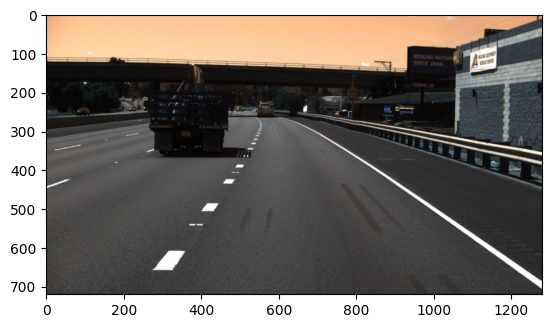

In [ ]:
# Read and display a test image
test_image = cv2.imread("/content/drive//MyDrive/unzipped_data/TUSimple/test_set/clips/0530/1492626047222176976_0/20.jpg")
plt.imshow(test_image)


In [ ]:
# Create a LaneDetector instance using the ENet model
detector = LaneDetector(enet=enet_model)

# Use the LaneDetector to process the test image and obtain results
res = detector(test_image)


Detected 3 lanes


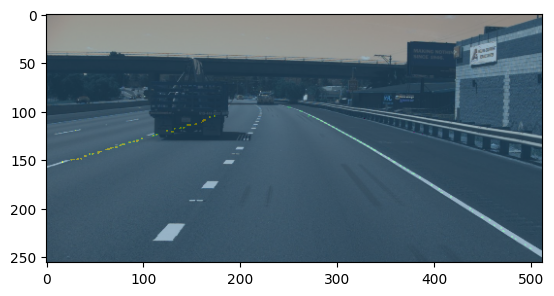

In [ ]:
# Display the original resized test image and overlay the detected lanes
plt.imshow(cv2.resize(test_image, (512, 256)))
plt.imshow(res[0], alpha=0.5)


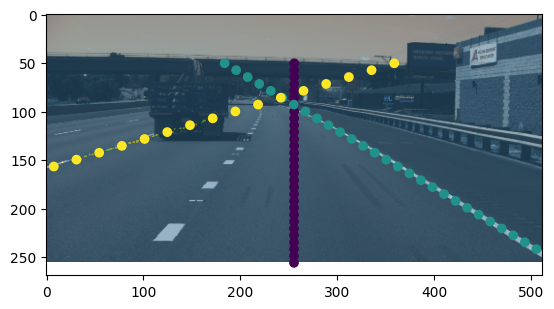

In [ ]:
# Display the original resized test image, overlay the detected lanes, and scatter plot lane points with different colors for each lane
plt.imshow(cv2.resize(test_image, (512, 256)))
plt.imshow(res[0], alpha=0.5)
plt.scatter(x=res[1][:, 0], y=res[1][:, 1], c=res[1][:, 2])


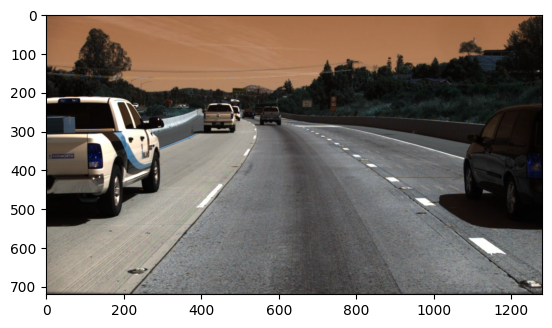

In [ ]:
# Read and display another test image
test_image_2 = cv2.imread("/content/drive//MyDrive/unzipped_data/TUSimple/test_set/clips/0530/1492626286076989589_0/20.jpg")
plt.imshow(test_image_2)


In [ ]:
# Use the LaneDetector to analyze lanes in the second test image
detector = LaneDetector(enet=enet_model)
res_2 = detector(test_image_2)


Detected 2 lanes


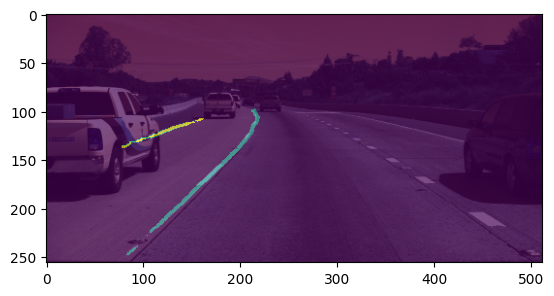

In [ ]:
# Display the second test image with the lane instances map overlaid
plt.imshow(cv2.resize(test_image_2, (512, 256)))
plt.imshow(res_2[0], alpha=0.7)


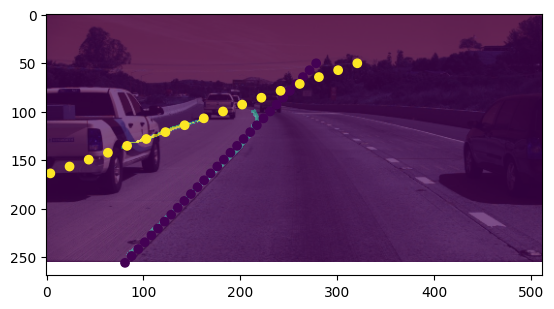

In [ ]:
# Display the second test image with the lane instances map overlaid and lane points scattered
plt.imshow(cv2.resize(test_image_2, (512, 256)))
plt.imshow(res_2[0], alpha=0.7)
plt.scatter(x=res_2[1][:, 0], y=res_2[1][:, 1], c=res_2[1][:, 2])


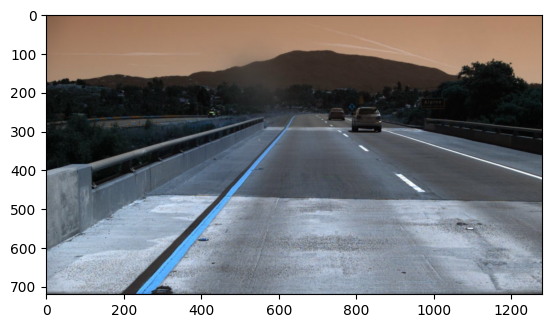

In [ ]:
# Display the third test image with the lane instances map overlaid
test_image_3 = cv2.imread("/content/drive//MyDrive/unzipped_data/TUSimple/test_set/clips/0531/1492626674406553912/20.jpg")
plt.imshow(test_image_3)

In [ ]:
# Use the LaneDetector to analyze lanes in the third test image
detector = LaneDetector(enet=enet_model)
res_3 = detector(test_image_3)

Detected 2 lanes


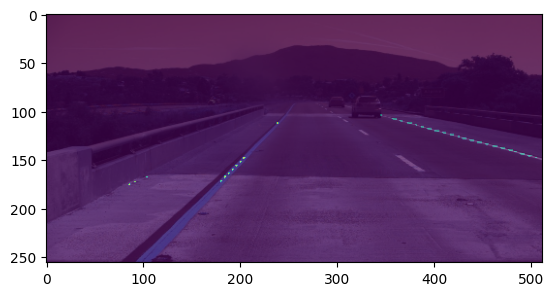

In [ ]:
# Display the third test image with the lane instances map overlaid
plt.imshow(cv2.resize(test_image_3, (512, 256)))
plt.imshow(res_3[0], alpha=0.7)

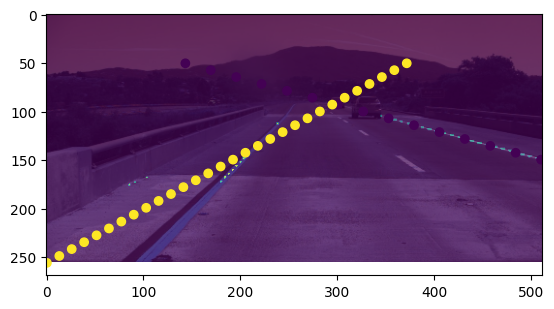

In [ ]:
# Display the third test image with the lane instances map overlaid and scatter plot of predicted lanes
plt.imshow(cv2.resize(test_image_3, (512, 256)))
plt.imshow(res_3[0], alpha=0.7)
plt.scatter(x=res_3[1][:, 0], y=res_3[1][:, 1], c=res_3[1][:, 2])


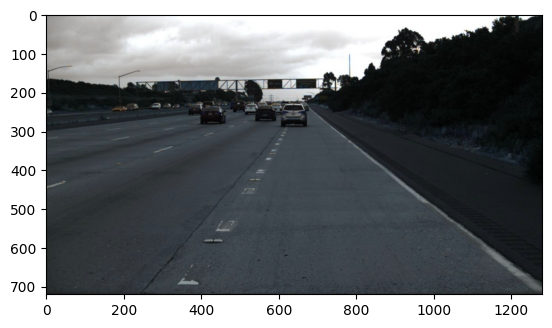

In [ ]:
# Display the fourth test image with the lane instances map overlaid
test_image_4 = cv2.imread("/content/drive//MyDrive/unzipped_data/TUSimple/test_set/clips/0601/1494452381594376146/20.jpg")
plt.imshow(test_image_4)

In [ ]:
# Use the LaneDetector to analyze lanes in the fourth test image
detector = LaneDetector(enet=enet_model)
res_4 = detector(test_image_4)

Detected 2 lanes


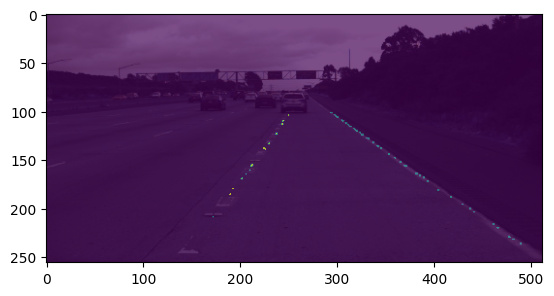

In [ ]:
# Display the fourth test image with the lane instances map overlaid
plt.imshow(cv2.resize(test_image_4, (512, 256)))
plt.imshow(res_4[0], alpha=0.7)

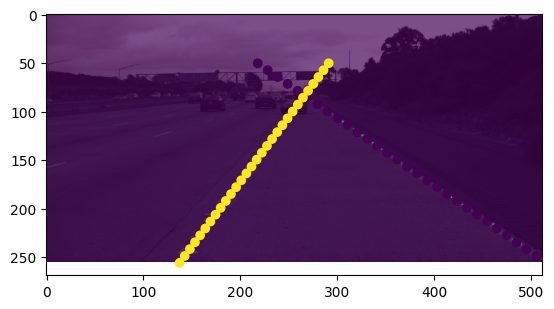

In [ ]:
# Display the fourth test image with the lane instances map overlaid and scatter plot of predicted lanes
plt.imshow(cv2.resize(test_image_4, (512, 256)))
plt.imshow(res_4[0], alpha=0.7)
plt.scatter(x=res_4[1][:,0], y=res_4[1][:, 1], c=res_4[1][:, 2])

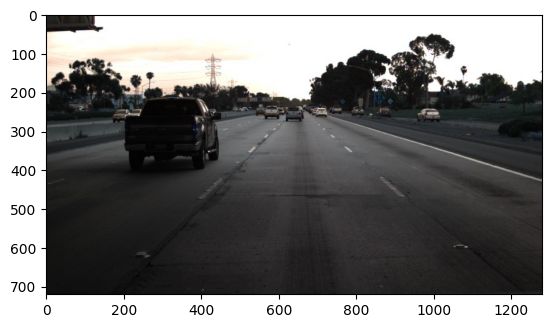

In [ ]:
# Display the fifth test image with the lane instances map overlaid
test_image_5 = cv2.imread("/content/drive//MyDrive/unzipped_data/TUSimple/test_set/clips/0601/1494452431571697487/20.jpg")
plt.imshow(test_image_5)

In [ ]:
# Use the LaneDetector to analyze lanes in the fifth test image
detector = LaneDetector(enet=enet_model)
res_5 = detector(test_image_5)

Detected 3 lanes


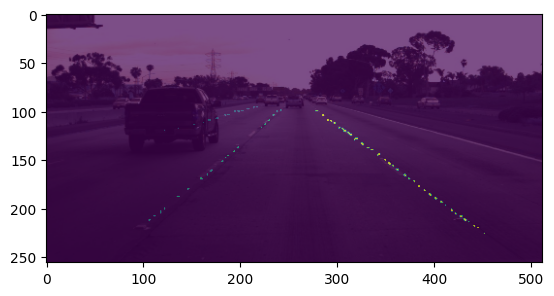

In [ ]:
# Display the fifth test image with the lane instances map overlaid
plt.imshow(cv2.resize(test_image_5, (512, 256)))
plt.imshow(res_5[0], alpha=0.7)

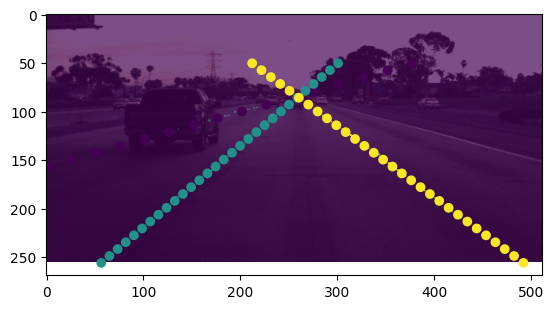

In [ ]:
# Display the fifth test image with the lane instances map overlaid and scatter plot of predicted lanes
plt.imshow(cv2.resize(test_image_5, (512, 256)))
plt.imshow(res_5[0], alpha=0.7)
plt.scatter(x=res_5[1][:,0], y=res_5[1][:, 1], c=res_5[1][:, 2])

# Deployment using streamlit


In [ ]:
# Install Streamlit package using pip
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0


In [ ]:
# Save the state dictionary of the trained ENet model to a file named 'lane_detection_model.pth'
import torch

# Assume 'model' is your trained lane detection model
torch.save(enet_model.state_dict(), 'lane_detection_model.pth')

In [ ]:
# Create an instance of the ENet model with the specified architecture
model = ENet(binary_seg=2, embedding_dim=4)

# Load the saved state dictionary from the file 'lane_detection_model.pth'
state_dict = torch.load('lane_detection_model.pth')

# Load the state dictionary into the ENet model
model.load_state_dict(state_dict)

# Switch the model to evaluation mode
model.eval()



ENet(
  (initial_block): InitialBlock(
    (main_branch): Conv2d(1, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_activation): PReLU(num_parameters=1)
  )
  (downsample1_0): DownsamplingBottleneck(
    (main_max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ext_conv1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_c